**Phone Price Prediction Using Regression - SVR AND Random Forest**

In [18]:
# Step 1: Loading Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Step 2: Loading the Dataset
file_path = file_path = r"C:\Users\user\Downloads\cleaned_all_phones.csv"  # Replace with your actual path
df = pd.read_csv(file_path)

# Step 3: Quick Overview
print("Dataset Shape:", df.shape)
df.head()

# Step 4: Data Types & Missing Values
print("\nData Info:")
df.info()

print("\nMissing Values:")
print(df.isnull().sum())

# Step 5: Basic Statistics
print("\nSummary Statistics:")
display(df.describe())

Dataset Shape: (1512, 22)

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1512 entries, 0 to 1511
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   phone_name         1512 non-null   object 
 1   brand              1512 non-null   object 
 2   os                 1512 non-null   object 
 3   inches             1512 non-null   float64
 4   resolution         1512 non-null   object 
 5   battery            1512 non-null   int64  
 6   battery_type       1512 non-null   object 
 7   ram(GB)            1512 non-null   int64  
 8   announcement_date  1512 non-null   object 
 9   weight(g)          1512 non-null   float64
 10  storage(GB)        1512 non-null   int64  
 11  video_720p         1512 non-null   bool   
 12  video_1080p        1512 non-null   bool   
 13  video_4K           1512 non-null   bool   
 14  video_8K           1512 non-null   bool   
 15  video_30fps        1512 non-null  

,inches,battery,ram(GB),weight(g),storage(GB),price(USD)
count,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000,1512.000000
mean,6.422460,4389.798942,6.683862,187.636243,109.164683,337.847036
std,0.477043,784.607022,2.701433,26.200115,74.436484,266.740821
min,3.800000,1821.000000,1.000000,130.000000,1.000000,40.000000
25%,6.300000,4000.000000,4.000000,175.000000,64.000000,179.997500
50%,6.500000,4500.000000,8.000000,187.000000,128.000000,260.000000
75%,6.670000,5000.000000,8.000000,197.250000,128.000000,400.000000
max,10.400000,7250.000000,24.000000,500.000000,512.000000,2300.000000


In [19]:
df.head()

,phone_name,brand,os,inches,resolution,battery,battery_type,ram(GB),announcement_date,weight(g),...,video_1080p,video_4K,video_8K,video_30fps,video_60fps,video_120fps,video_240fps,video_480fps,video_960fps,price(USD)
0,Y6II Compact,Huawei,Android 5.1,5.0,720x1280,2200,Li-Po,2,2016-09-01,140.0,...,False,False,False,True,False,False,False,False,False,120.0
1,K20 plus,LG,Android 7.0,5.3,720x1280,2700,Li-Ion,2,2016-12-01,140.0,...,True,False,False,True,False,False,False,False,False,100.0
2,P8 Lite (2017),Huawei,Android 7.0,5.2,1080x1920,3000,Li-Ion,4,2017-01-01,147.0,...,True,False,False,True,False,False,False,False,False,420.0
3,Redmi Note 4,Xiaomi,Android 6.0,5.5,1080x1920,4100,Li-Po,4,2017-01-01,165.0,...,True,False,False,True,False,True,False,False,False,150.0
4,P10,Huawei,Android 7.0,5.1,1080x1920,3200,Li-Ion,4,2017-02-01,145.0,...,True,True,False,True,True,False,False,False,False,420.0


**DATA VISUALIZATION**

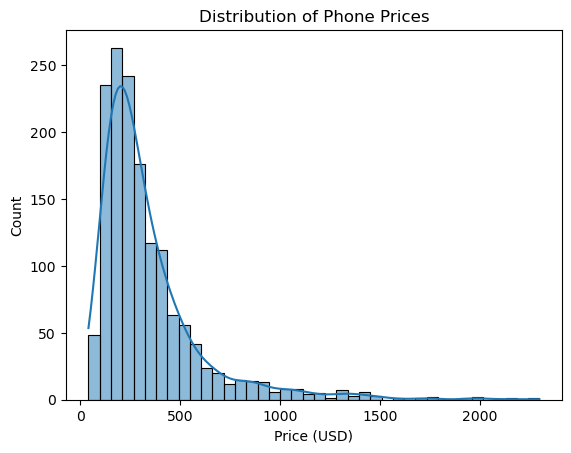

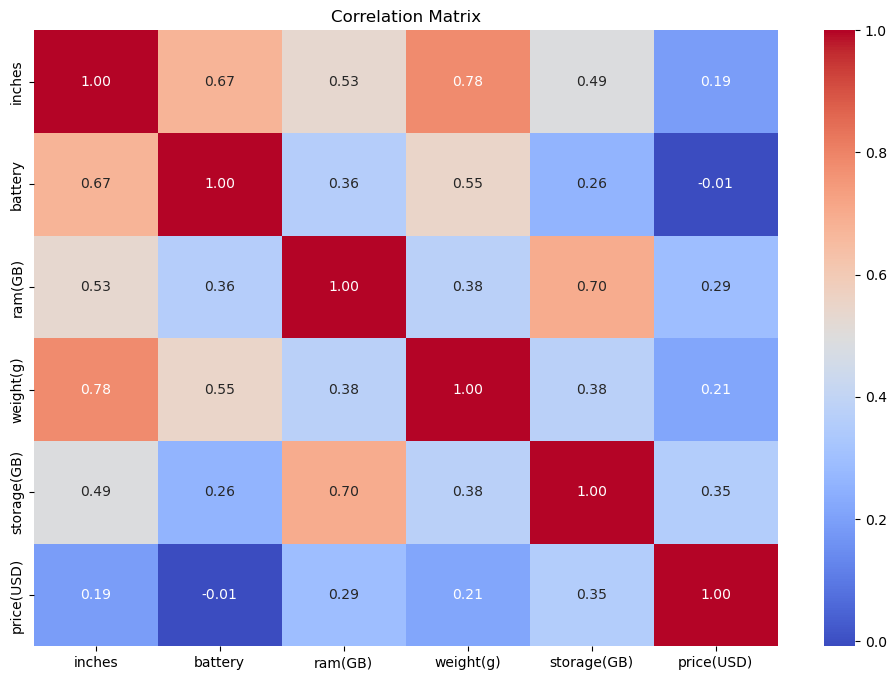

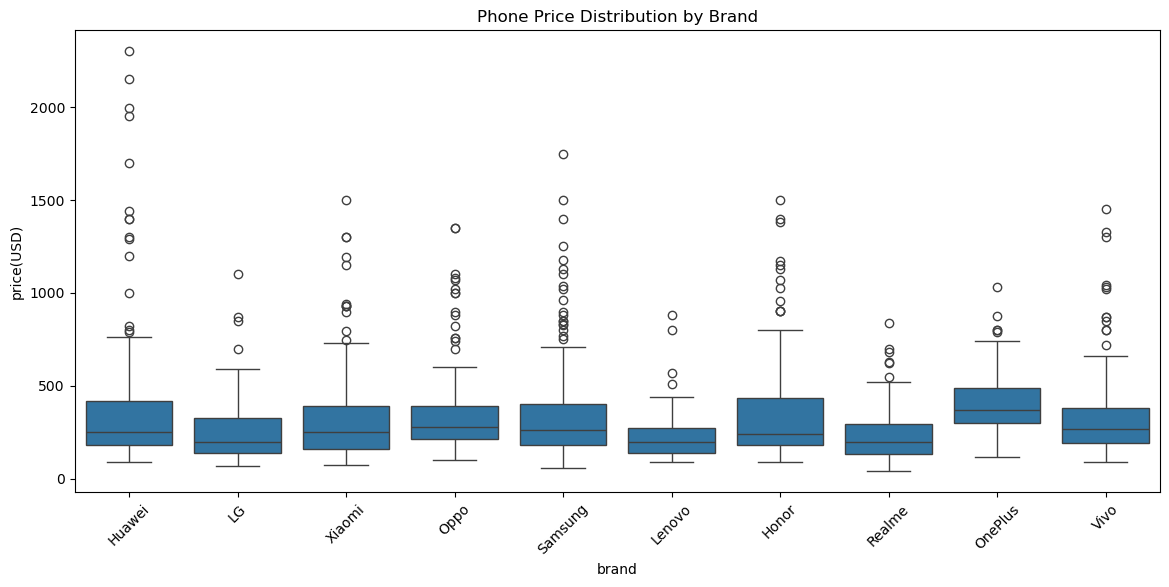

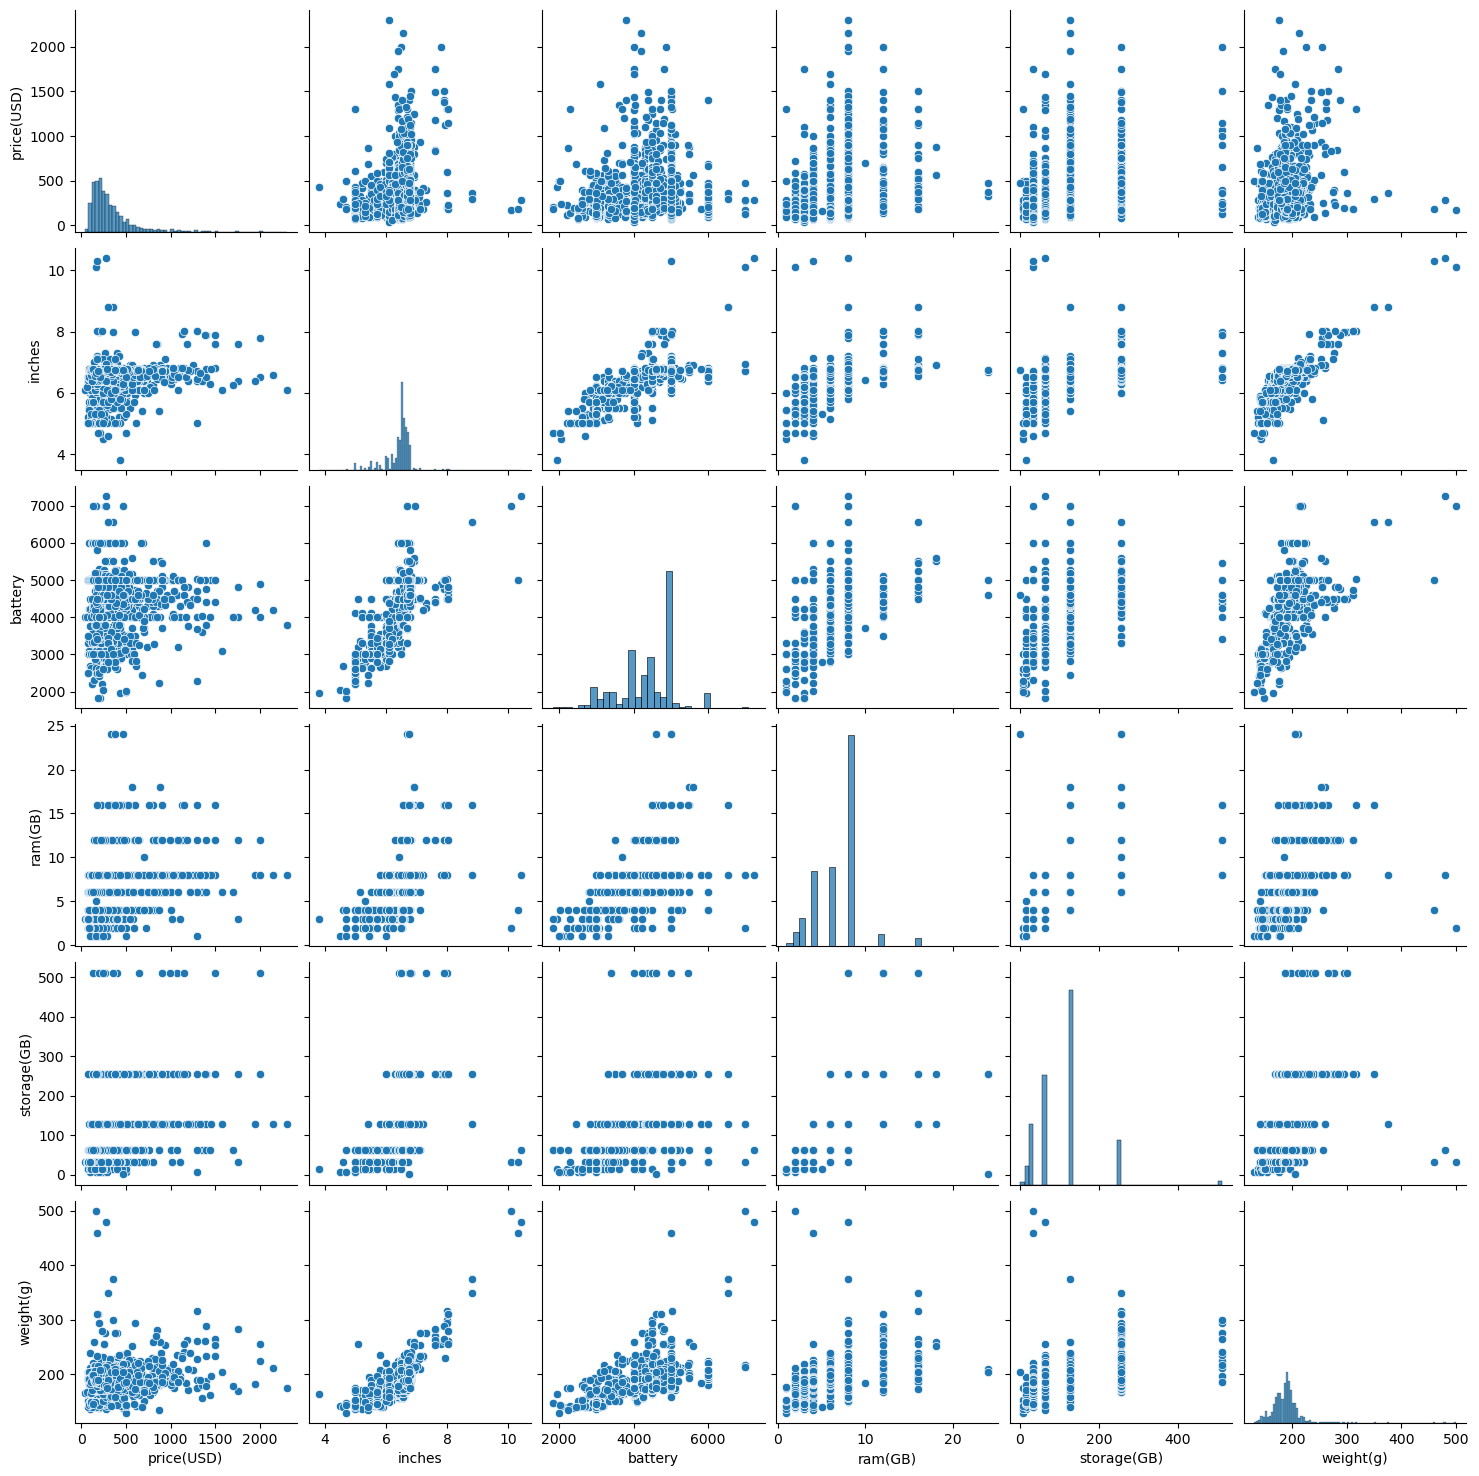

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Distribution of Target Variable
sns.histplot(df['price(USD)'], kde=True, bins=40)
plt.title("Distribution of Phone Prices")
plt.xlabel("Price (USD)")
plt.ylabel("Count")
plt.show()

# 2. Correlation Heatmap (Numerical Features Only)
numerical_df = df.select_dtypes(include=['float64', 'int64'])
plt.figure(figsize=(12, 8))
sns.heatmap(numerical_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

# 3. Boxplot: Price by Brand
plt.figure(figsize=(14, 6))
top_brands = df['brand'].value_counts().nlargest(10).index
sns.boxplot(data=df[df['brand'].isin(top_brands)], x='brand', y='price(USD)')
plt.xticks(rotation=45)
plt.title("Phone Price Distribution by Brand")
plt.show()

# 4. Pairplot 
selected_features = ['price(USD)', 'inches', 'battery', 'ram(GB)', 'storage(GB)', 'weight(g)']
sns.pairplot(df[selected_features])
plt.show()


**TRAIN TEST SPLIT AND LABEL ENCODING**

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Making copy to avoid changing original data
data = df.copy()

# Droping unnecessary columns
data.drop(columns=['phone_name'], inplace=True)

# Extracting announcement year and changing to datetime
data['announcement_year'] = pd.to_datetime(data['announcement_date'], errors='coerce').dt.year
data.drop(columns=['announcement_date'], inplace=True)

# Defining target and features
X = data.drop(columns=['price(USD)'])
y = data['price(USD)']

# Identifing column types
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()

# Building preprocessing pipeline
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_features)
])

# Fiting and transforming the features
X_processed = preprocessor.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

print("Preprocessing complete.")
print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")


Preprocessing complete.
Train shape: (1209, 159), Test shape: (303, 159)


 **Model Implementation - Random Forest & SVR**

In [25]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initialize models
rf_model = RandomForestRegressor(random_state=42)
svr_model = SVR()

# Defining hyperparameter grids for both models
rf_param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

svr_param_grid = {
    'C': [1, 10, 100],
    'gamma': ['scale', 'auto'],
    'kernel': ['linear', 'rbf']
}

# Hyperparameter tuning with GridSearchCV
rf_grid_search = GridSearchCV(estimator=rf_model, param_grid=rf_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)
svr_grid_search = GridSearchCV(estimator=svr_model, param_grid=svr_param_grid, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1, verbose=1)

# Fiting models to the training data
rf_grid_search.fit(X_train, y_train)
svr_grid_search.fit(X_train, y_train)

# Best models and parameters
print("Best parameters for Random Forest:", rf_grid_search.best_params_)
print("Best parameters for SVR:", svr_grid_search.best_params_)

# Evaluating models on the test set
rf_best_model = rf_grid_search.best_estimator_
svr_best_model = svr_grid_search.best_estimator_

rf_predictions = rf_best_model.predict(X_test)
svr_predictions = svr_best_model.predict(X_test)

# Calculating evaluation metrics
def evaluate_model(predictions, true_values):
    mae = mean_absolute_error(true_values, predictions)
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_values, predictions)
    return mae, mse, rmse, r2

# Random Forest evaluation
rf_mae, rf_mse, rf_rmse, rf_r2 = evaluate_model(rf_predictions, y_test)

# SVR evaluation
svr_mae, svr_mse, svr_rmse, svr_r2 = evaluate_model(svr_predictions, y_test)

# Display evaluation results
print(f"Random Forest - MAE: {rf_mae}, MSE: {rf_mse}, RMSE: {rf_rmse}, R²: {rf_r2}")
print(f"SVR - MAE: {svr_mae}, MSE: {svr_mse}, RMSE: {svr_rmse}, R²: {svr_r2}")


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_split': 10, 'n_estimators': 200}
Best parameters for SVR: {'C': 100, 'gamma': 'scale', 'kernel': 'rbf'}
Random Forest - MAE: 139.49175834522225, MSE: 57561.6866694966, RMSE: 239.9201672838209, R²: 0.1820292445233821
SVR - MAE: 127.70369424357992, MSE: 54475.832277512134, RMSE: 233.40058328442998, R²: 0.22588026408775463


**TABULATED RESULTS**

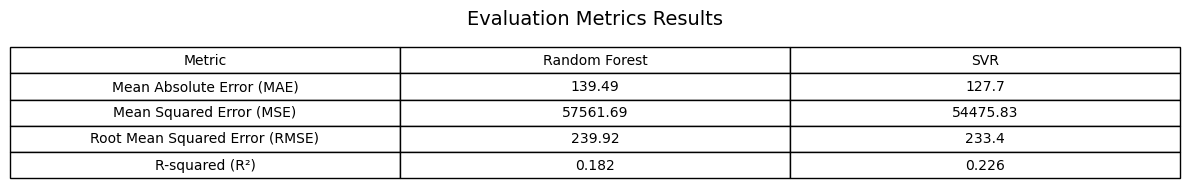

In [27]:
import pandas as pd
import matplotlib.pyplot as plt

# Evaluation results
data = {
    'Metric': [
        'Mean Absolute Error (MAE)', 
        'Mean Squared Error (MSE)', 
        'Root Mean Squared Error (RMSE)', 
        'R-squared (R²)'
    ],
    'Random Forest': [
        139.49,
        57561.69,
        239.92,
        0.182
    ],
    'SVR': [
        127.70,
        54475.83,
        233.40,
        0.226
    ]
}

# Create DataFrame
df = pd.DataFrame(data)

# Display as a styled table
fig, ax = plt.subplots(figsize=(12, 2))  # Adjust height as needed
ax.axis('off')
tbl = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 2)  # Adjust scale to improve readability
plt.title('Evaluation Metrics Results', fontsize=14, pad=20)
plt.tight_layout()
plt.show()


**VISUALISAITON OF EVALUATION METRICS FOR BOTH MODELS**

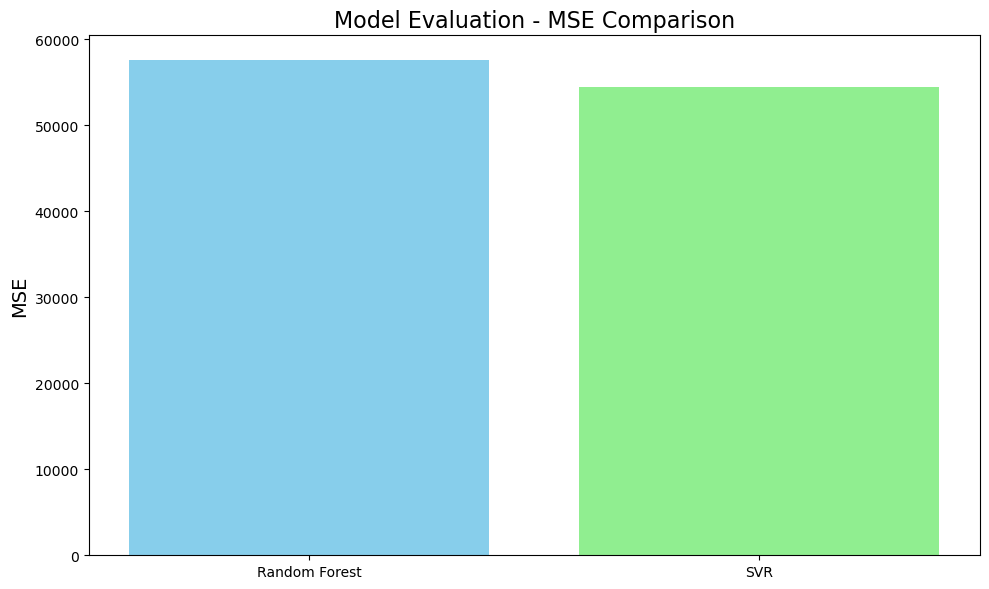

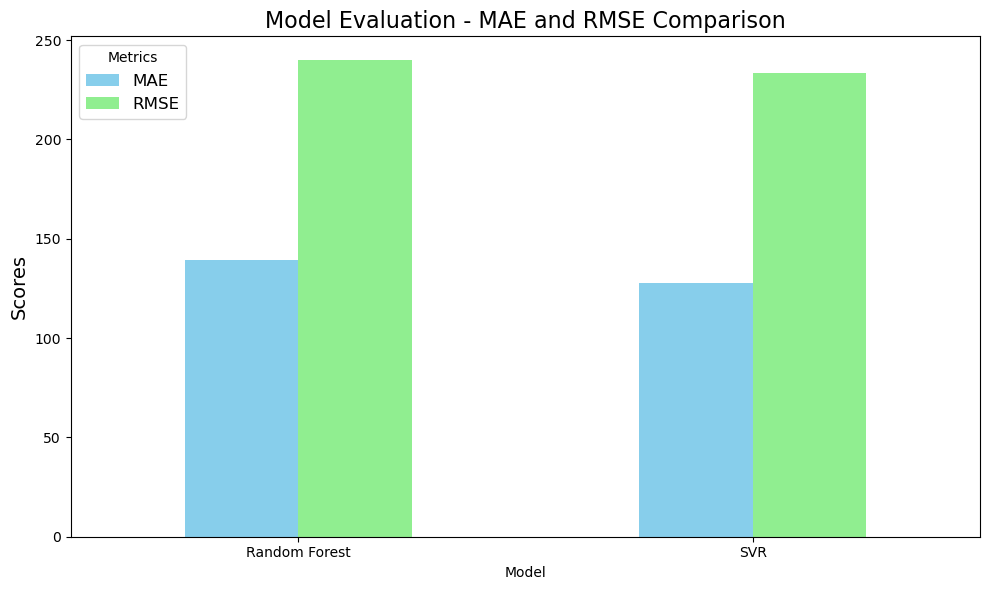

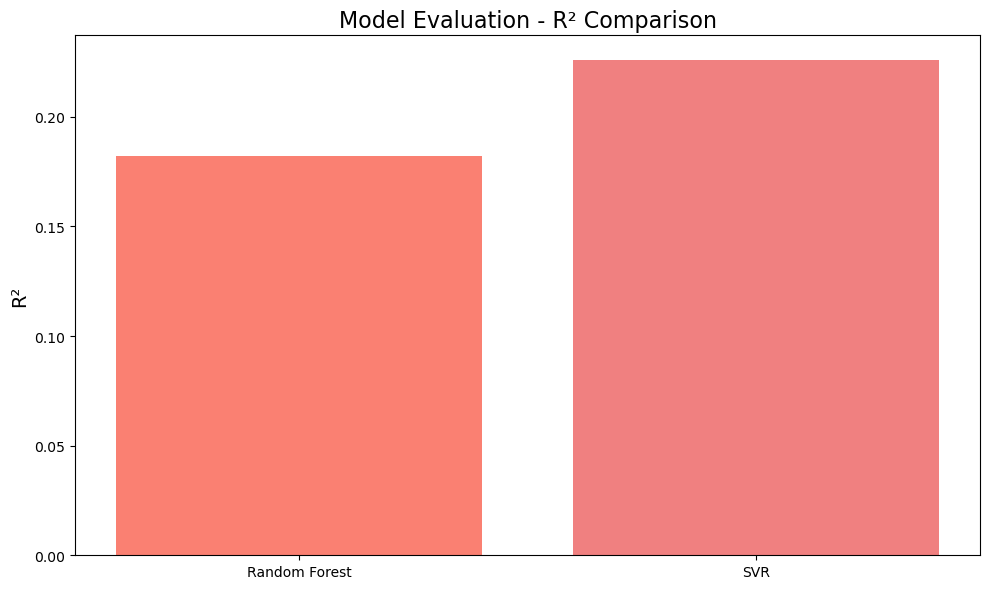

In [29]:
import matplotlib.pyplot as plt
import pandas as pd

# Creating a DataFrame for the results
results = {
    'Model': ['Random Forest', 'SVR'],
    'MAE': [139.49, 127.70],
    'MSE': [57561.69, 54475.83],
    'RMSE': [239.92, 233.40],
    'R²': [0.1820, 0.2259]
}

df_results = pd.DataFrame(results)

# Plotting MSE separately due to its larger scale
plt.figure(figsize=(10,6))
plt.bar(df_results['Model'], df_results['MSE'], color=['skyblue', 'lightgreen'])
plt.title('Model Evaluation - MSE Comparison', fontsize=16)
plt.ylabel('MSE', fontsize=14)
plt.tight_layout()
plt.show()

# Plotting MAE and RMSE together in one plot
df_results.set_index('Model')[['MAE', 'RMSE']].plot(kind='bar', figsize=(10,6), color=['skyblue', 'lightgreen'])

# Adding labels and title for the second plot
plt.title('Model Evaluation - MAE and RMSE Comparison', fontsize=16)
plt.ylabel('Scores', fontsize=14)
plt.xticks(rotation=0)
plt.legend(title='Metrics', fontsize=12)
plt.tight_layout()
plt.show()

# Plotting R² separately due to its small scale
plt.figure(figsize=(10,6))
plt.bar(df_results['Model'], df_results['R²'], color=['salmon', 'lightcoral'])
plt.title('Model Evaluation - R² Comparison', fontsize=16)
plt.ylabel('R²', fontsize=14)
plt.tight_layout()
plt.show()


**PREDICTING THE PRICE OF A PHONE**

In [38]:
import pandas as pd

# Example input for a new phone
new_phone = pd.DataFrame([{
    'brand': 'Samsung',
    'os': 'Android',
    'inches': 6.5,
    'resolution': '1080x2400',
    'battery': 5000,
    'battery_type': 'Li-Po',
    'ram(GB)': 8,
    'announcement_date': '2023-11-01',
    'weight(g)': 190,
    'storage(GB)': 128,
    'video_720p': True,
    'video_1080p': True,
    'video_4K': True,
    'video_8K': False,
    'video_30fps': True,
    'video_60fps': True,
    'video_120fps': False,
    'video_240fps': False,
    'video_480fps': False,
    'video_960fps': False
}])

# Apply preprocessing (if you used any like OneHotEncoder, ColumnTransformer, etc.)
new_phone_processed = preprocessor.transform(new_phone)

# Predict using the trained model (e.g., best_rf)
predicted_price = rf_best_model.predict(new_phone_processed)

print(f"Predicted price (USD): ${predicted_price[0]:.2f}")

Predicted price (USD): $304.36


In [46]:
new_phone = pd.DataFrame([{
    'phone_name': 'Y6II Compact',
    'brand': 'Huawei',
    'os': 'Android 5.1',
    'inches': 5.0,
    'resolution': '720x1280',
    'battery': 2200,
    'battery_type': 'Li-Po',
    'ram(GB)': 2,
    'storage(GB)': 8,  
    'announcement_date': '2016-09-01',
    'weight(g)': 140.0,
    'video_720p': True,
    'video_1080p': False,
    'video_4K': False,
    'video_8K': False,
    'video_30fps': True,
    'video_60fps': False,
    'video_120fps': False,
    'video_240fps': False,
    'video_480fps': False,
    'video_960fps': False
}])

# Droping phone_name 
new_phone.drop(columns=['phone_name'], inplace=True)

# Transform and predict
new_phone_processed = preprocessor.transform(new_phone)
predicted_price = rf_best_model.predict(new_phone_processed)

print(f"Predicted price (USD): ${predicted_price[0]:.2f}")


Predicted price (USD): $224.60
